global file
file = input('Selet a folder to save output') ##enter your file path here - the file is in the repo "summary_stats.csv".
raw_file = file

In [2438]:
from datetime import datetime
from datetime import date
from subgrounds.subgraph import SyntheticField, FieldPath
from subgrounds.subgrounds import Subgrounds
import math
import pandas as pd
import  os as os
import duckdb as db
import seaborn as sns
import matplotlib.pyplot as plt

In [2439]:
sg = Subgrounds()
snapshot = sg.load_api('https://hub.snapshot.org/graphql')

In [2440]:
snapshot.Proposal.datetime = SyntheticField(
  lambda timestamp: str(datetime.fromtimestamp(timestamp)),
  SyntheticField.STRING,
  snapshot.Proposal.end,
)

In [2441]:
spacename = input('spacename plz?')
# based on their url, for example "curve.eth" for  https://snapshot.org/#/curve.eth
proposals = snapshot.Query.proposals(
  orderBy='created',
  orderDirection='desc',
  first=10000,
  where=[
    snapshot.Proposal.space == spacename, ##'fuse.eth',
    snapshot.Proposal.state == 'closed'
    ##snapshot.Proposal.title == 'OIP-18: Reward rate framework and reduction',
  ]
)

In [2442]:
proposals_snapshots = sg.query_df([
    proposals.title,
    proposals.id,
    proposals.body,
    proposals.scores_total
])

In [2443]:
proposals_choices = sg.query(proposals.choices)

In [2444]:
proposals_choices = pd.DataFrame(proposals_choices)

In [2445]:
olympus_governance_view = pd.concat([proposals_snapshots,proposals_choices], axis=1)

In [2446]:
##let's view the output just to make sure
olympus_governance_view.head(5)

,proposals_title,proposals_id,proposals_body,proposals_scores_total,0,1,2,3,4,5,6
0,[AIP-9] Deposit Liquidation Treasury Funds int...,0xb0178d17b7accd319622d4a0246d4a5affb570d2006f...,Summary:\n--\nDeposit a portion of liquidation...,1.883793e+07,YES - deposit in lending pools,NO - keep the fund as is,None,None,None,None,None
1,[AIP-8.2] Increase AUSD utility by providing a...,0x388adc3eecab51a667fc6e972fc28a99cf3f04dbc249...,"Background:\n--\n\nIn March, we announced mult...",1.538519e+07,$1 AUSD3EPS locked for $1 alloc,$1.5 AUSD3EPS locked for $1alloc,$2 AUSD3EPS locked for $1 alloc,$2.5 AUSD3EPS locked for $1alloc,$3 AUSD3EPS locked for $1 alloc,$3.5 AUSD3EPS locked for $1alloc,$4 AUSD3EPS locked for $1 alloc
2,[AIP-8] Increase AUSD utility by providing acc...,0x1b0121dd1093823d70cc472d69df0f9dae151ddb099d...,"Background:\n--\n\nIn March, we announced mult...",2.067421e+07,Yes - access to AUSD3EPS holders,No - only keep access to xALPACA,None,None,None,None,None
3,[AIP-7] Handling of a recent bad debt on Fanto...,0xa019fbf7a75ba04ba3cdc2ddbeb6fe5945029e7adde6...,## Background\nDuring the last week’s market c...,1.422233e+07,Yes - Activate insurance plan,No - Do not activate,None,None,None,None,None
4,[AIP-6.2] Limiting Access to Automated Vault,0xacf2e3fa9c9fba868a8908cd3e4e6f133baecc8e5cdd...,## Background:\n\nDue to strong demand for Aut...,1.498553e+07,$1.0 ALPACA locked for $1 alloc,$1.5 ALPACA locked for $1 alloc,$2.0 ALPACA locked for $1 alloc,$2.5 ALPACA locked for $1 alloc,$3.0 ALPACA locked for $1 alloc,None,None


In [2447]:
#let's remove duplicate rows the easy way, and add the name of the DAO to the table
olympus_governance_view_clean = olympus_governance_view.copy(deep=True)
olympus_governance_view_clean.insert(0, 'DAO', spacename)
olympus_governance_view_clean.head(10)

,DAO,proposals_title,proposals_id,proposals_body,proposals_scores_total,0,1,2,3,4,5,6
0,alpacafinance.eth,[AIP-9] Deposit Liquidation Treasury Funds int...,0xb0178d17b7accd319622d4a0246d4a5affb570d2006f...,Summary:\n--\nDeposit a portion of liquidation...,1.883793e+07,YES - deposit in lending pools,NO - keep the fund as is,None,None,None,None,None
1,alpacafinance.eth,[AIP-8.2] Increase AUSD utility by providing a...,0x388adc3eecab51a667fc6e972fc28a99cf3f04dbc249...,"Background:\n--\n\nIn March, we announced mult...",1.538519e+07,$1 AUSD3EPS locked for $1 alloc,$1.5 AUSD3EPS locked for $1alloc,$2 AUSD3EPS locked for $1 alloc,$2.5 AUSD3EPS locked for $1alloc,$3 AUSD3EPS locked for $1 alloc,$3.5 AUSD3EPS locked for $1alloc,$4 AUSD3EPS locked for $1 alloc
2,alpacafinance.eth,[AIP-8] Increase AUSD utility by providing acc...,0x1b0121dd1093823d70cc472d69df0f9dae151ddb099d...,"Background:\n--\n\nIn March, we announced mult...",2.067421e+07,Yes - access to AUSD3EPS holders,No - only keep access to xALPACA,None,None,None,None,None
3,alpacafinance.eth,[AIP-7] Handling of a recent bad debt on Fanto...,0xa019fbf7a75ba04ba3cdc2ddbeb6fe5945029e7adde6...,## Background\nDuring the last week’s market c...,1.422233e+07,Yes - Activate insurance plan,No - Do not activate,None,None,None,None,None
4,alpacafinance.eth,[AIP-6.2] Limiting Access to Automated Vault,0xacf2e3fa9c9fba868a8908cd3e4e6f133baecc8e5cdd...,## Background:\n\nDue to strong demand for Aut...,1.498553e+07,$1.0 ALPACA locked for $1 alloc,$1.5 ALPACA locked for $1 alloc,$2.0 ALPACA locked for $1 alloc,$2.5 ALPACA locked for $1 alloc,$3.0 ALPACA locked for $1 alloc,None,None
5,alpacafinance.eth,[AIP-6.1] Limiting Access to Automated Vault,0x397181c03837f52d82584976574fd239370147eeecd4...,## Background:\n\nDue to strong demand for Aut...,1.347131e+07,"Yes, limit access to high-lev AV","No, don't limit access to AV",None,None,None,None,None
6,alpacafinance.eth,[AIP-5] Interest Model Adjustment,0x3d7abd61ef0560febf667ce4754fc7bc0c76cc99d654...,## Background:\n\nWhen we first launched Alpac...,8.460068e+06,"Yes, adjust the interest model","No, don't adjust the interest",None,None,None,None,None
7,alpacafinance.eth,[AIP-4.2] Solution to eliminate bad debt risks...,0xb4f4a29393b7918116766b1ba84781d677941934b705...,\n\n## Background:\n\nWith WaultSwap’s migrati...,1.124149e+07,Yes - close remaining positions,No - leave them as is,None,None,None,None,None
8,alpacafinance.eth,[AIP-4.1] Handling of a recent bad debt on Wau...,0xec36d90586f65a2bceef31be5625551e34d0d1ecb9da...,\n## Background:\n\nWith WaultSwap’s migration...,1.101115e+07,Yes - activate insurance plan,No - do not activate,None,None,None,None,None
9,alpacafinance.eth,[AIP-3] Handling of Governance Vault’s Early W...,0xe7afd7ccfb551ddad7d5f2e3ae77271ec93a2b1d8d3c...,"Dear Alpacas,\n\nWe published an article last ...",1.703636e+07,100% to burn,75% to burn 25% to stakers,50% to burn 50% to stakers,25% to burn 75% to stakers,100% to stakers,None,None


In [2448]:
path =file+'/'+spacename+'_proposals_table_'+str(date.today().strftime("%b-%d-%Y"))+'_'+str(len(olympus_governance_view_clean))+'_proposals.csv'
olympus_governance_view_clean.to_csv(path, index = False)

In [2449]:
total_proposals = len(olympus_governance_view_clean)
total_proposals

14

In [2450]:
proposal_id = olympus_governance_view_clean.iloc[0,2]
proposal_id

'0xb0178d17b7accd319622d4a0246d4a5affb570d2006f7aff8014158fc722cff2'

In [2451]:
vote_tracker = snapshot.Query.votes(
orderBy = 'created',
orderDirection='desc',
first=10000,
where=[
  snapshot.Vote.proposal == proposal_id
]
)

In [2452]:
voting_snapshots_list = sg.query_df([
    vote_tracker.id,
    vote_tracker.voter,
    vote_tracker.created,
    vote_tracker.choice,
    vote_tracker.vp
])

In [2453]:
voting_snapshots_list.head(10)

,votes_id,votes_voter,votes_created,votes_choice,votes_vp
0,0x3235bd4a55619d8085426efe3581e76fd1d75e2db9a4...,0xC79AEdf1e551100F8F21fb4CC2aa6eF65EF86aec,1656701123,1,12.259188
1,0xc5bc51025cecb00b004e68aa2fbc20db8827f3c93a0c...,0x06E84Ad48a328E2B7c4dfB172C4eDFB9FBa6bd9b,1656695592,1,1.438375
2,0x022ff0e5e53312ead2c255fb9e316a687dfd5e71e9bc...,0xCC459846FF7587A972CaEFF28315c8D20390c4bd,1656694696,1,2.019461
3,0xaaac661eb93d857e341e9ffbe111d0ff85ba6cd1940d...,0x819Fec659e1C225ce330B02e01f1e4c629E92A7a,1656686143,1,3.125678
4,0x1a868730b58dd78d24e7b74f6a026e9672733390cd9d...,0x29fc901F2D79908d4B36028Ea973305e47Fc4810,1656685227,1,6.642497
5,0x6a4c8b3180c7cfe562bef9c55a1ed2d4e00aaea5311f...,0x0c6d11e18319Ab12965c3025045B96c7A714a71A,1656679331,1,3990.683220
6,0xcdf195e1d892a143996304b41f40334edf302954446b...,0x13FB49bD78E18fFF091c0B9019f052F1dd6d7433,1656679309,1,425.631377
7,0x665e7e26251977d76efa02d52ae949b2af8ad7cc616f...,0x986fCC6B0D290308aD6F6A0e8471F74f53dec06a,1656678976,1,1832.341989
8,0x32ff7f76a34918ace25363e6e98c5cdf58c8b437b00a...,0xD3E4d4Bf274f8A8fF2542959fcdD3C5E112CAb34,1656674832,1,0.435065
9,0xc9cd14ca3e13cc6bdf74724b730d538404558348150d...,0x80fFCAaeBF3a602A88f479B622DD5AA857844508,1656674539,1,75769.447931


In [2454]:
x=0
while x <total_proposals:
    proposal_id = olympus_governance_view_clean.iloc[x,2]

    vote_tracker = snapshot.Query.votes(
    orderBy = 'created',
    orderDirection='desc',
    first=10000,
    where=[
      snapshot.Vote.proposal == proposal_id
    ]
    )
    voting_snapshots = sg.query_df([
    vote_tracker.id,
    vote_tracker.voter,
    vote_tracker.created,
    vote_tracker.choice,
    vote_tracker.vp
    ])

    voting_snapshots['Proposal'] = proposal_id
    voting_snapshots_list=pd.concat([voting_snapshots_list, voting_snapshots])

    x=x+1
    progress = 100*(round(x/total_proposals,0))
    ##clear_output(wait=True)

print(len(voting_snapshots_list),' records')

13638  records


In [2455]:
#spit out the file
path =file+'/'+spacename+'_voting_snapshots_list_'+str(date.today().strftime("%b-%d-%Y"))+'_'+str(len(olympus_governance_view_clean))+'.csv'
voting_snapshots_list.to_csv(path, index = False)

In [2456]:
#I join these two tables to create my charts as it makes life easier. We are going to build the charts here now, so here we go
governance_data = pd.merge(voting_snapshots_list, olympus_governance_view_clean, how='inner', left_on='Proposal', right_on='proposals_id')
del governance_data["proposals_body"]
governance_data.head(10)

,votes_id,votes_voter,votes_created,votes_choice,votes_vp,Proposal,DAO,proposals_title,proposals_id,proposals_scores_total,0,1,2,3,4,5,6
0,0x3235bd4a55619d8085426efe3581e76fd1d75e2db9a4...,0xC79AEdf1e551100F8F21fb4CC2aa6eF65EF86aec,1656701123,1,12.259188,0xb0178d17b7accd319622d4a0246d4a5affb570d2006f...,alpacafinance.eth,[AIP-9] Deposit Liquidation Treasury Funds int...,0xb0178d17b7accd319622d4a0246d4a5affb570d2006f...,1.883793e+07,YES - deposit in lending pools,NO - keep the fund as is,None,None,None,None,None
1,0xc5bc51025cecb00b004e68aa2fbc20db8827f3c93a0c...,0x06E84Ad48a328E2B7c4dfB172C4eDFB9FBa6bd9b,1656695592,1,1.438375,0xb0178d17b7accd319622d4a0246d4a5affb570d2006f...,alpacafinance.eth,[AIP-9] Deposit Liquidation Treasury Funds int...,0xb0178d17b7accd319622d4a0246d4a5affb570d2006f...,1.883793e+07,YES - deposit in lending pools,NO - keep the fund as is,None,None,None,None,None
2,0x022ff0e5e53312ead2c255fb9e316a687dfd5e71e9bc...,0xCC459846FF7587A972CaEFF28315c8D20390c4bd,1656694696,1,2.019461,0xb0178d17b7accd319622d4a0246d4a5affb570d2006f...,alpacafinance.eth,[AIP-9] Deposit Liquidation Treasury Funds int...,0xb0178d17b7accd319622d4a0246d4a5affb570d2006f...,1.883793e+07,YES - deposit in lending pools,NO - keep the fund as is,None,None,None,None,None
3,0xaaac661eb93d857e341e9ffbe111d0ff85ba6cd1940d...,0x819Fec659e1C225ce330B02e01f1e4c629E92A7a,1656686143,1,3.125678,0xb0178d17b7accd319622d4a0246d4a5affb570d2006f...,alpacafinance.eth,[AIP-9] Deposit Liquidation Treasury Funds int...,0xb0178d17b7accd319622d4a0246d4a5affb570d2006f...,1.883793e+07,YES - deposit in lending pools,NO - keep the fund as is,None,None,None,None,None
4,0x1a868730b58dd78d24e7b74f6a026e9672733390cd9d...,0x29fc901F2D79908d4B36028Ea973305e47Fc4810,1656685227,1,6.642497,0xb0178d17b7accd319622d4a0246d4a5affb570d2006f...,alpacafinance.eth,[AIP-9] Deposit Liquidation Treasury Funds int...,0xb0178d17b7accd319622d4a0246d4a5affb570d2006f...,1.883793e+07,YES - deposit in lending pools,NO - keep the fund as is,None,None,None,None,None
5,0x6a4c8b3180c7cfe562bef9c55a1ed2d4e00aaea5311f...,0x0c6d11e18319Ab12965c3025045B96c7A714a71A,1656679331,1,3990.683220,0xb0178d17b7accd319622d4a0246d4a5affb570d2006f...,alpacafinance.eth,[AIP-9] Deposit Liquidation Treasury Funds int...,0xb0178d17b7accd319622d4a0246d4a5affb570d2006f...,1.883793e+07,YES - deposit in lending pools,NO - keep the fund as is,None,None,None,None,None
6,0xcdf195e1d892a143996304b41f40334edf302954446b...,0x13FB49bD78E18fFF091c0B9019f052F1dd6d7433,1656679309,1,425.631377,0xb0178d17b7accd319622d4a0246d4a5affb570d2006f...,alpacafinance.eth,[AIP-9] Deposit Liquidation Treasury Funds int...,0xb0178d17b7accd319622d4a0246d4a5affb570d2006f...,1.883793e+07,YES - deposit in lending pools,NO - keep the fund as is,None,None,None,None,None
7,0x665e7e26251977d76efa02d52ae949b2af8ad7cc616f...,0x986fCC6B0D290308aD6F6A0e8471F74f53dec06a,1656678976,1,1832.341989,0xb0178d17b7accd319622d4a0246d4a5affb570d2006f...,alpacafinance.eth,[AIP-9] Deposit Liquidation Treasury Funds int...,0xb0178d17b7accd319622d4a0246d4a5affb570d2006f...,1.883793e+07,YES - deposit in lending pools,NO - keep the fund as is,None,None,None,None,None
8,0x32ff7f76a34918ace25363e6e98c5cdf58c8b437b00a...,0xD3E4d4Bf274f8A8fF2542959fcdD3C5E112CAb34,1656674832,1,0.435065,0xb0178d17b7accd319622d4a0246d4a5affb570d2006f...,alpacafinance.eth,[AIP-9] Deposit Liquidation Treasury Funds int...,0xb0178d17b7accd319622d4a0246d4a5affb570d2006f...,1.883793e+07,YES - deposit in lending pools,NO - keep the fund as is,None,None,None,None,None
9,0xc9cd14ca3e13cc6bdf74724b730d538404558348150d...,0x80fFCAaeBF3a602A88f479B622DD5AA857844508,1656674539,1,75769.447931,0xb0178d17b7accd319622d4a0246d4a5affb570d2006f...,alpacafinance.eth,[AIP-9] Deposit Liquidation Treasury Funds int...,0xb0178d17b7accd319622d4a0246d4a5affb570d2006f...,1.883793e+07,YES - deposit in lending pools,NO - keep the fund as is,None,None,None,None,None


In [2457]:
#Spit out the file, but save it in its own folder for easy access
final_file = file+'\\'+'final'
final_raw_file = final_file
os.makedirs(final_raw_file, exist_ok=True)
final_path =file+'\\'+spacename+'governance_data_'+str(date.today().strftime("%b-%d-%Y"))+'_'+str(len(governance_data))+'.csv'
governance_data.to_csv(final_path, index = False)

In [2458]:
crunch_data = db.query("select "
                           "Proposal"
                           ",votes_voter "
                           ",votes_choice"
                           ",votes_vp"
                           ",votes_created"
                           ",sum(votes_vp) over (Partition by Proposal  order by votes_vp desc, votes_created asc) as cumulative_vp"
                           ",sum(votes_vp) over (Partition by Proposal) as total_vp"
                           ",(votes_vp::decimal/sum(votes_vp::decimal) over (Partition by Proposal)) as percentage_of_total_vp "
                           ",((sum(votes_vp) over (Partition by Proposal  order by votes_vp desc, votes_created asc))::decimal/sum(votes_vp::decimal) over (Partition by Proposal)) as cum_percentage_of_total_vp "
                       ",round((sum(votes_vp) over (Partition by Proposal  order by votes_vp desc, votes_created asc))::decimal/sum(votes_vp::decimal) over (Partition by Proposal)) as cum_percentage_of_total_vp_stepped "
                           ",row_number() over (Partition by Proposal order by votes_vp desc, votes_created asc) as proposal_voter_rank "
                           ",count(votes_voter) over (Partition by Proposal  order by votes_vp desc, votes_created asc) total_voters "
                           ",(count(*) over (Partition by Proposal  order by votes_vp desc, votes_created asc))::decimal/(count(*) over (Partition by Proposal))::decimal percentage_voters_counted "
                           ",round(100*(count(*) over (Partition by Proposal  order by votes_vp desc, votes_created asc))::decimal/(count(*) over (Partition by Proposal)))::decimal percentage_voters_counted_stepped "
                       "from "
                       "    governance_data  "
                       ""
                       "Group by "
                       "    Proposal"
                       "    ,votes_voter"
                       "    ,votes_choice"
                       "    , votes_vp "
                       "    , votes_created "
                       ""
                       "Order by "
                       "    Proposal, "
                       "    votes_vp desc "
                       "    , votes_created asc"
                       "").df()


crunch_data.insert(0, 'DAO', spacename)
crunch_data.head(n=10)


,DAO,Proposal,votes_voter,votes_choice,votes_vp,votes_created,cumulative_vp,total_vp,percentage_of_total_vp,cum_percentage_of_total_vp,cum_percentage_of_total_vp_stepped,proposal_voter_rank,total_voters,percentage_voters_counted,percentage_voters_counted_stepped
0,alpacafinance.eth,0x1b0121dd1093823d70cc472d69df0f9dae151ddb099d...,0xda4Ee24723cCf8F7Ad840Ce4647049F91fF664FE,2,4.062019e+06,1654578126,4.062019e+06,2.067421e+07,0.196478,0.196478,0.0,1,1,0.001256,0.0
1,alpacafinance.eth,0x1b0121dd1093823d70cc472d69df0f9dae151ddb099d...,0xdF7B69C22B96F2C7e07687971551021058260451,1,2.683916e+06,1654577612,6.745935e+06,2.067421e+07,0.129820,0.326297,0.0,2,2,0.002513,0.0
2,alpacafinance.eth,0x1b0121dd1093823d70cc472d69df0f9dae151ddb099d...,0x4Ea21fE653AF9B524333512Db3605830Cc2fE592,1,1.329190e+06,1654576650,8.075125e+06,2.067421e+07,0.064292,0.390589,0.0,3,3,0.003769,0.0
3,alpacafinance.eth,0x1b0121dd1093823d70cc472d69df0f9dae151ddb099d...,0x466B32918a35d8C290793A99DD37B6e14BCF3e92,1,9.852133e+05,1654701963,9.060339e+06,2.067421e+07,0.047654,0.438244,0.0,4,4,0.005025,1.0
4,alpacafinance.eth,0x1b0121dd1093823d70cc472d69df0f9dae151ddb099d...,0x0Cd910313B5631EE1Cd9700cFEF8b61A11b22187,1,9.482794e+05,1654752023,1.000862e+07,2.067421e+07,0.045868,0.484111,0.0,5,5,0.006281,1.0
5,alpacafinance.eth,0x1b0121dd1093823d70cc472d69df0f9dae151ddb099d...,0x29FeC057B86eF46d240Bd271837369f5715335EF,2,8.582843e+05,1654689827,1.086690e+07,2.067421e+07,0.041515,0.525626,1.0,6,6,0.007538,1.0
6,alpacafinance.eth,0x1b0121dd1093823d70cc472d69df0f9dae151ddb099d...,0x1823b5C394a3bdd564E8761b9a39E0441B4c0C86,1,8.097588e+05,1654738803,1.167666e+07,2.067421e+07,0.039168,0.564794,1.0,7,7,0.008794,1.0
7,alpacafinance.eth,0x1b0121dd1093823d70cc472d69df0f9dae151ddb099d...,0x47BD4AED4e9AFBAa651E1bB5548C2C0d1b362148,2,5.948703e+05,1654662124,1.227153e+07,2.067421e+07,0.028774,0.593567,1.0,8,8,0.010050,1.0
8,alpacafinance.eth,0x1b0121dd1093823d70cc472d69df0f9dae151ddb099d...,0xB5df3AA5E5F7B480f57F144C063062abCc253131,2,5.159563e+05,1654875300,1.278749e+07,2.067421e+07,0.024957,0.618524,1.0,9,9,0.011307,1.0
9,alpacafinance.eth,0x1b0121dd1093823d70cc472d69df0f9dae151ddb099d...,0x31033A1F43d255d1A20BF9c517E17368Ce6F55F6,2,4.111558e+05,1654889951,1.319864e+07,2.067421e+07,0.019887,0.638411,1.0,10,10,0.012563,1.0


In [2459]:
#leaders = crunch_data.loc[crunch_data['proposal_voter_rank'] <=3]
#leader_count = leaders.votes_voter.nunique()
#leader_count
#DONT ASK ME WHY THIS DIDNT WORK. HAVE TO DO IT THE UGLY WAY

leader_ranks = db.query("with leader_ranks as "
                        "(Select distinct "
                        "   B.Proposal"
                        "   ,B.votes_voter"
                        "   ,B.proposal_voter_rank "
                        "   ,(B.proposal_voter_rank +1) as leader_rank "
                        "From "
                        "   (select "
                               "Proposal"
                               ",votes_voter "
                               ",votes_choice"
                               ",votes_vp"
                               ",votes_created"
                               ",sum(votes_vp) over (Partition by Proposal  order by votes_vp desc, votes_created asc) as cumulative_vp"
                               ",sum(votes_vp) over (Partition by Proposal) as total_vp"
                               ",(votes_vp::decimal/sum(votes_vp::decimal) over (Partition by Proposal)) as percentage_of_total_vp "
                               ",((sum(votes_vp) over (Partition by Proposal  order by votes_vp desc, votes_created asc))::decimal/sum(votes_vp::decimal) over (Partition by Proposal)) as cum_percentage_of_total_vp "
                           "    ,round((sum(votes_vp) over (Partition by Proposal  order by votes_vp desc, votes_created asc))::decimal/sum(votes_vp::decimal) over (Partition by Proposal)) as cum_percentage_of_total_vp_stepped "
                               ",row_number() over (Partition by Proposal order by votes_vp desc, votes_created asc) as proposal_voter_rank "
                               ",count(votes_voter) over (Partition by Proposal  order by votes_vp desc, votes_created asc) total_voters "
                               ",(count(*) over (Partition by Proposal  order by votes_vp desc, votes_created asc))::decimal/(count(*) over (Partition by Proposal))::decimal percentage_voters_counted "
                               ",round(100*(count(*) over (Partition by Proposal  order by votes_vp desc, votes_created asc))::decimal/(count(*) over (Partition by Proposal)))::decimal percentage_voters_counted_stepped "
                           "from "
                           "    governance_data  "
                               ""
                           "Group by "
                           "    Proposal"
                           "    ,votes_voter"
                           "    ,votes_choice"
                           "    , votes_vp "
                           "    , votes_created "
                           ""
                           "Order by "
                           "    Proposal, "
                           "    votes_vp desc "
                           "    , votes_created asc) B "
                        "where "
                        "   B.cum_percentage_of_total_vp<=0.5) "
                        ""
                        "Select "
                        "   *"
                        "From crunch_data A"
                        "   Join leader_ranks B on A.proposal_voter_rank = B.leader_rank and A.Proposal = B.Proposal"
                        ""
                    ).df()
leader_ranks



,DAO,Proposal,votes_voter,votes_choice,votes_vp,votes_created,cumulative_vp,total_vp,percentage_of_total_vp,cum_percentage_of_total_vp,cum_percentage_of_total_vp_stepped,proposal_voter_rank,total_voters,percentage_voters_counted,percentage_voters_counted_stepped,Proposal_2,votes_voter_2,proposal_voter_rank_2,leader_rank
0,alpacafinance.eth,0x1b0121dd1093823d70cc472d69df0f9dae151ddb099d...,0xdF7B69C22B96F2C7e07687971551021058260451,1,2.683916e+06,1654577612,6.745935e+06,2.067421e+07,0.129820,0.326297,0.0,2,2,0.002513,0.0,0x1b0121dd1093823d70cc472d69df0f9dae151ddb099d...,0xda4Ee24723cCf8F7Ad840Ce4647049F91fF664FE,1,2
1,alpacafinance.eth,0x1b0121dd1093823d70cc472d69df0f9dae151ddb099d...,0x4Ea21fE653AF9B524333512Db3605830Cc2fE592,1,1.329190e+06,1654576650,8.075125e+06,2.067421e+07,0.064292,0.390589,0.0,3,3,0.003769,0.0,0x1b0121dd1093823d70cc472d69df0f9dae151ddb099d...,0xdF7B69C22B96F2C7e07687971551021058260451,2,3
2,alpacafinance.eth,0x1b0121dd1093823d70cc472d69df0f9dae151ddb099d...,0x466B32918a35d8C290793A99DD37B6e14BCF3e92,1,9.852133e+05,1654701963,9.060339e+06,2.067421e+07,0.047654,0.438244,0.0,4,4,0.005025,1.0,0x1b0121dd1093823d70cc472d69df0f9dae151ddb099d...,0x4Ea21fE653AF9B524333512Db3605830Cc2fE592,3,4
3,alpacafinance.eth,0x1b0121dd1093823d70cc472d69df0f9dae151ddb099d...,0x0Cd910313B5631EE1Cd9700cFEF8b61A11b22187,1,9.482794e+05,1654752023,1.000862e+07,2.067421e+07,0.045868,0.484111,0.0,5,5,0.006281,1.0,0x1b0121dd1093823d70cc472d69df0f9dae151ddb099d...,0x466B32918a35d8C290793A99DD37B6e14BCF3e92,4,5
4,alpacafinance.eth,0x1b0121dd1093823d70cc472d69df0f9dae151ddb099d...,0x29FeC057B86eF46d240Bd271837369f5715335EF,2,8.582843e+05,1654689827,1.086690e+07,2.067421e+07,0.041515,0.525626,1.0,6,6,0.007538,1.0,0x1b0121dd1093823d70cc472d69df0f9dae151ddb099d...,0x0Cd910313B5631EE1Cd9700cFEF8b61A11b22187,5,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120,alpacafinance.eth,0xe7afd7ccfb551ddad7d5f2e3ae77271ec93a2b1d8d3c...,0xd09fA948296E54D1Ab73A0497C16403A08A84732,3,5.277579e+05,1648111644,2.878492e+07,6.145981e+07,0.008587,0.468354,0.0,35,35,0.013834,1.0,0xe7afd7ccfb551ddad7d5f2e3ae77271ec93a2b1d8d3c...,0xd09fA948296E54D1Ab73A0497C16403A08A84732,34,35
121,alpacafinance.eth,0xe7afd7ccfb551ddad7d5f2e3ae77271ec93a2b1d8d3c...,0xB5df3AA5E5F7B480f57F144C063062abCc253131,2,4.903193e+05,1648149217,3.123652e+07,6.145981e+07,0.007978,0.508243,1.0,36,40,0.015810,2.0,0xe7afd7ccfb551ddad7d5f2e3ae77271ec93a2b1d8d3c...,0xd09fA948296E54D1Ab73A0497C16403A08A84732,35,36
122,alpacafinance.eth,0xec36d90586f65a2bceef31be5625551e34d0d1ecb9da...,0x4Ea21fE653AF9B524333512Db3605830Cc2fE592,1,1.124849e+06,1648396534,4.338272e+06,1.101115e+07,0.102155,0.393989,0.0,2,2,0.004819,0.0,0xec36d90586f65a2bceef31be5625551e34d0d1ecb9da...,0xdF7B69C22B96F2C7e07687971551021058260451,1,2
123,alpacafinance.eth,0xec36d90586f65a2bceef31be5625551e34d0d1ecb9da...,0x0280f96A1eAb668c11C0537435796DAd6e16Efd0,1,6.843505e+05,1648599717,5.022622e+06,1.101115e+07,0.062151,0.456140,0.0,3,3,0.007229,1.0,0xec36d90586f65a2bceef31be5625551e34d0d1ecb9da...,0x4Ea21fE653AF9B524333512Db3605830Cc2fE592,2,3


In [2460]:
dao_members = crunch_data.groupby('DAO').votes_voter.nunique()
dao_members = dao_members.iloc[0]
leader_count =leader_ranks.votes_voter.nunique()
elite = round((leader_count)/(dao_members),4)

print(dao_members, "{0:.2%}".format(elite))


1613 1.61%


In [2461]:
##spit out the file!
crunch_data_path =final_file+'\\'+spacename+'_crunch_data_path'+str(date.today().strftime("%b-%d-%Y"))+'_'+str(len(crunch_data))+'.csv'
crunch_data.to_csv(crunch_data_path, index = False)

In [2462]:
data_means = crunch_data.groupby("percentage_voters_counted_stepped")["cum_percentage_of_total_vp", "percentage_voters_counted"].agg("mean").reset_index()
data_means =final_file+'\\'+spacename+'data_means_'+str(date.today().strftime("%b-%d-%Y"))+'_'+str(len(crunch_data))+'.csv'
crunch_data.to_csv(crunch_data_path, index = False)

C:\Users\ianfe\AppData\Local\Temp\ipykernel_50768\4246157564.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  data_means = crunch_data.groupby("percentage_voters_counted_stepped")["cum_percentage_of_total_vp", "percentage_voters_counted"].agg("mean").reset_index()


C:\Users\ianfe\AppData\Local\Temp\ipykernel_50768\2233744753.py:4: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  data_means = crunch_data.groupby("percentage_voters_counted_stepped")["cum_percentage_of_total_vp","percentage_voters_counted"].agg("mean").reset_index()


AxesSubplot(0.125,0.125;0.775x0.755)


,percentage_voters_counted_stepped,cum_percentage_of_total_vp,percentage_voters_counted
0,0.0,0.270265,0.003017
1,1.0,0.499518,0.009803
2,2.0,0.658161,0.019680
3,3.0,0.735390,0.029637
4,4.0,0.787691,0.039639
...,...,...,...
96,96.0,1.000000,0.960361
97,97.0,1.000000,0.970363
98,98.0,1.000000,0.980320
99,99.0,1.000000,0.990197


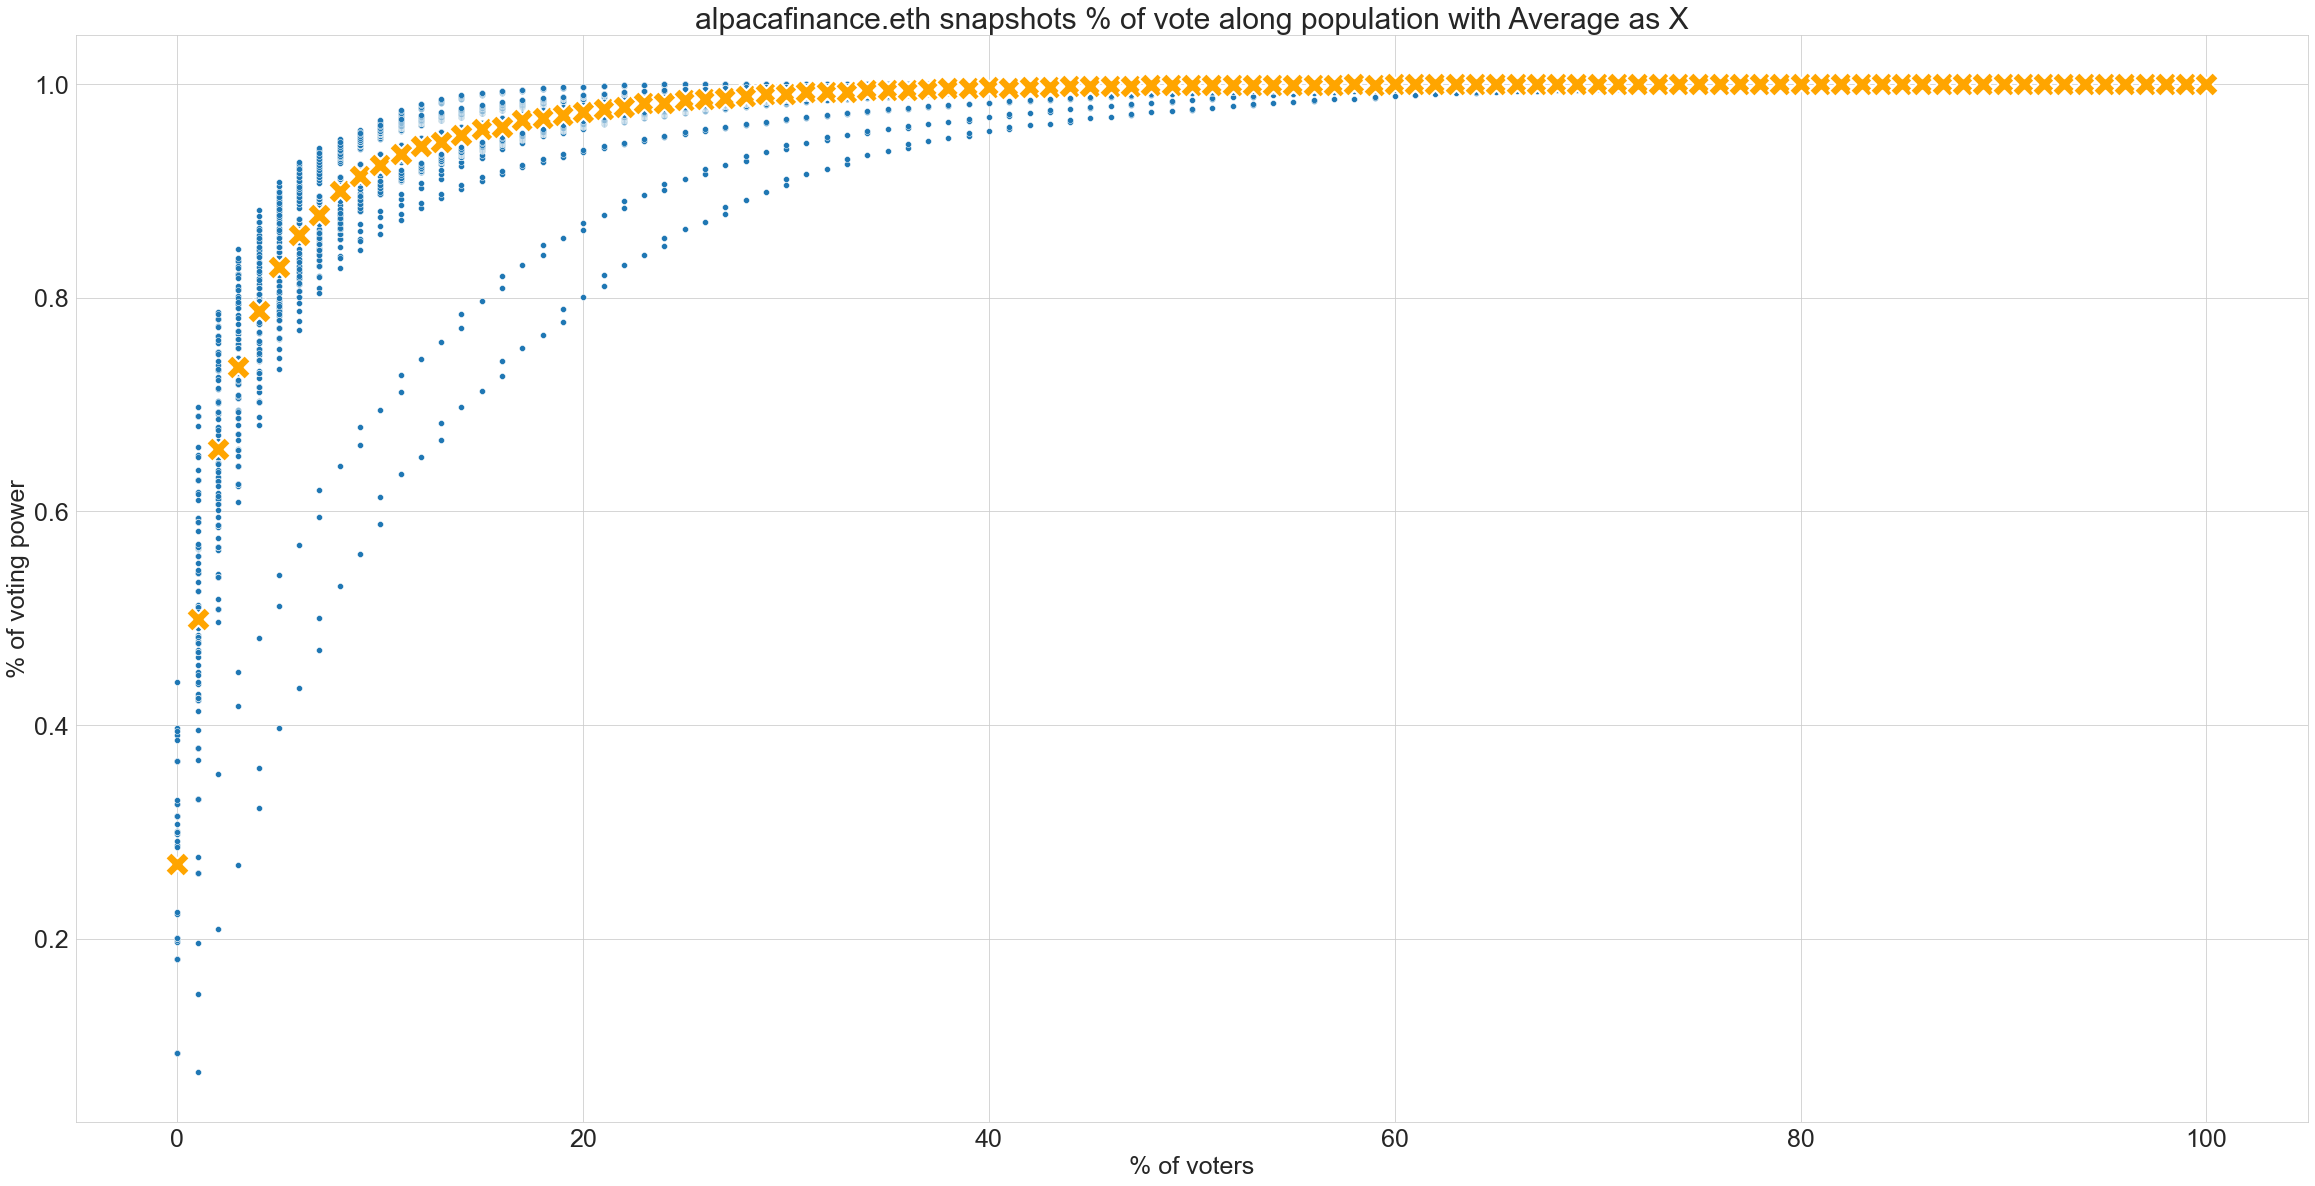

In [2463]:
plt.rc("figure", figsize=(40, 20))
sns.set_style("whitegrid")
plt.rc("font", size=25)
data_means = crunch_data.groupby("percentage_voters_counted_stepped")["cum_percentage_of_total_vp","percentage_voters_counted"].agg("mean").reset_index()
##print(data_means)
plot_title = spacename + ' snapshots % of vote along population with Average as X'

ax=sns.scatterplot(data=crunch_data, y="cum_percentage_of_total_vp",x="percentage_voters_counted_stepped").set(title=plot_title,xlabel='% of voters',ylabel='% of voting power')
chart = sns.scatterplot(data=data_means,x="percentage_voters_counted_stepped",y="cum_percentage_of_total_vp",zorder=3, s=600,marker='X',color = 'orange')
#and save the chart file, too
plt.savefig(final_file+'\\'+spacename+' vote power distribution.png', dpi=100)

means_data_path =final_file+'\\'+spacename+'_means_'+'.csv'
data_means.to_csv(means_data_path, index = False)

print(chart)
data_means

The chart above shows what % of all possible votes has been cast (Y axis) as each incremental percent of the voting population casts their vote (X axis). Each line is a Proposal and has a unique color, so that a dot on each percent point represents what % of total voting power was accumulated by that group. The color represents which vote was cast.
The Orange X shows the average % of power accumulated across all elections.

In [2464]:
p50 = db.query("select min(percentage_voters_counted) "
               "from data_means  where cum_percentage_of_total_vp>=0.5 ").df()
p50display = round(100*(p50.iloc[0,0]),2)
print('On average, a proposal at ', spacename, 'takes ',p50display,'% of the voting population.')

print('A total of ',leader_count, 'wallets have driven the result of all proposals at',spacename,)
print('That\'s', ("{0:.2%}".format(elite)), 'of all DAO voters.')

On average, a proposal at  alpacafinance.eth takes  1.97 % of the voting population.
A total of  26 wallets have driven the result of all proposals at alpacafinance.eth
That's 1.61% of all DAO voters.
